## Week-1

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

### 2. Importing the datasets

In [2]:
sales_data    = pd.read_excel("ProductA.xlsx")
google_clicks = pd.read_excel("ProductA_google_clicks.xlsx")
impressions   = pd.read_excel("ProductA_fb_impressions.xlsx")

### 3. Merging datasets

In [3]:
data    = pd.merge(sales_data, google_clicks, on="Day Index", how="left")
dataset = pd.merge(data, impressions, on="Day Index", how="left")

In [4]:
dataset.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


### 4. Descriptive Statistics

In [5]:
# Shape of the data in rows & columns

rows,columns = dataset.shape

print("Total number of rows : ",rows)
print("Total number of columns : ",columns)

Total number of rows :  212
Total number of columns :  4


In [6]:
# Basic info and structure
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.3 KB


In [7]:
dataset.columns

Index(['Day Index', 'Quantity', 'Clicks', 'Impressions'], dtype='object')

In [8]:
# Data type of each column
dataset.dtypes

Day Index      datetime64[ns]
Quantity                int64
Clicks                  int64
Impressions             int64
dtype: object

In [9]:
# Basic statistics for numerical columns
dataset.describe()

,Quantity,Clicks,Impressions
count,212.000000,212.00000,212.000000
mean,17.542453,358.20283,1531.702830
std,5.790423,164.52160,440.660783
min,5.000000,60.00000,620.000000
25%,13.750000,154.00000,1209.750000
50%,17.000000,402.50000,1460.000000
75%,21.000000,492.75000,1862.000000
max,38.000000,726.00000,2707.000000


## Week-2

## EXPLORATORY DATA ANALYSIS

### 5. Handling missing values

In [10]:
# Check for missing values in the dataset
print(dataset.isnull().sum())

Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64


=> There are no missing values in the dataset

### 6. Data visualisation

Text(0.5, 1.0, 'Day Index Vs Quantity')

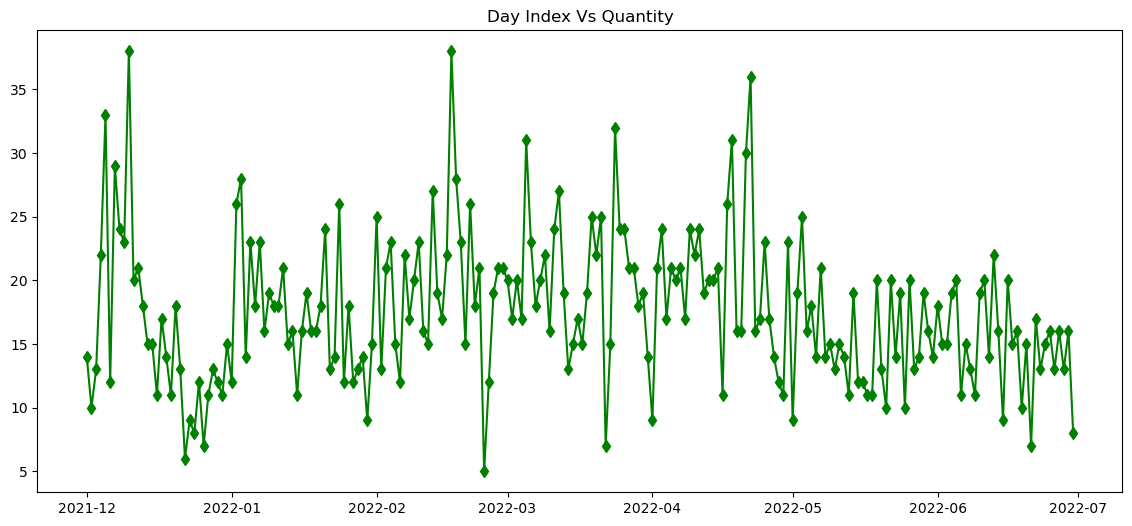

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(dataset['Day Index'],dataset['Quantity'],marker='d',c='green')
plt.title("Day Index Vs Quantity")

    ➡️There are more sales in the months of December, March, May

Text(0.5, 1.0, 'Day Index Vs Impressions')

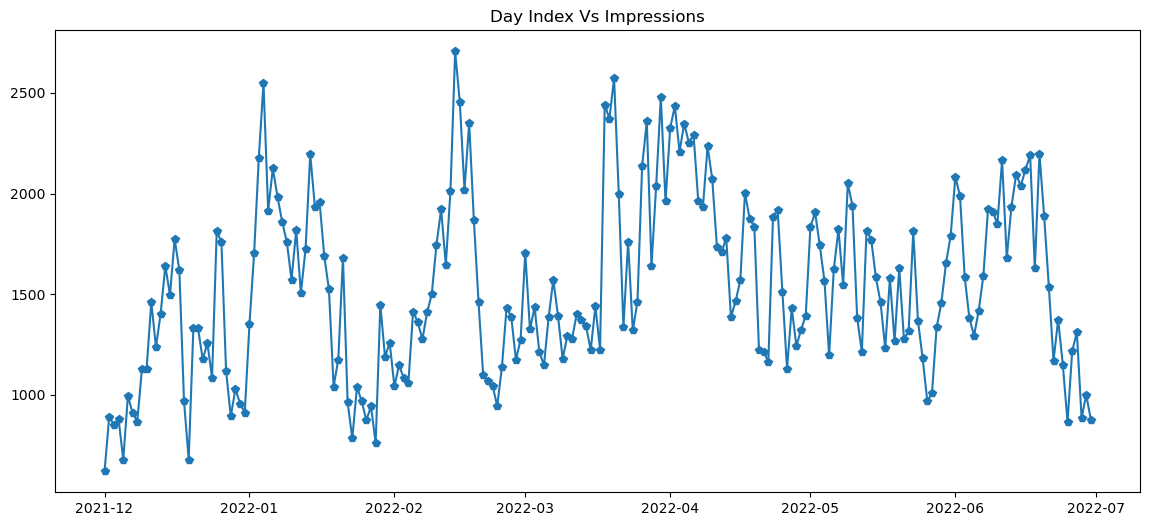

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(dataset['Day Index'],dataset['Impressions'],marker='p')
plt.title("Day Index Vs Impressions")

    The graph shows daily fluctuations in impressions, with notable peaks around January and April 2022, indicating periodic increases in activity.

Text(0.5, 1.0, 'Day Index Vs Clicks')

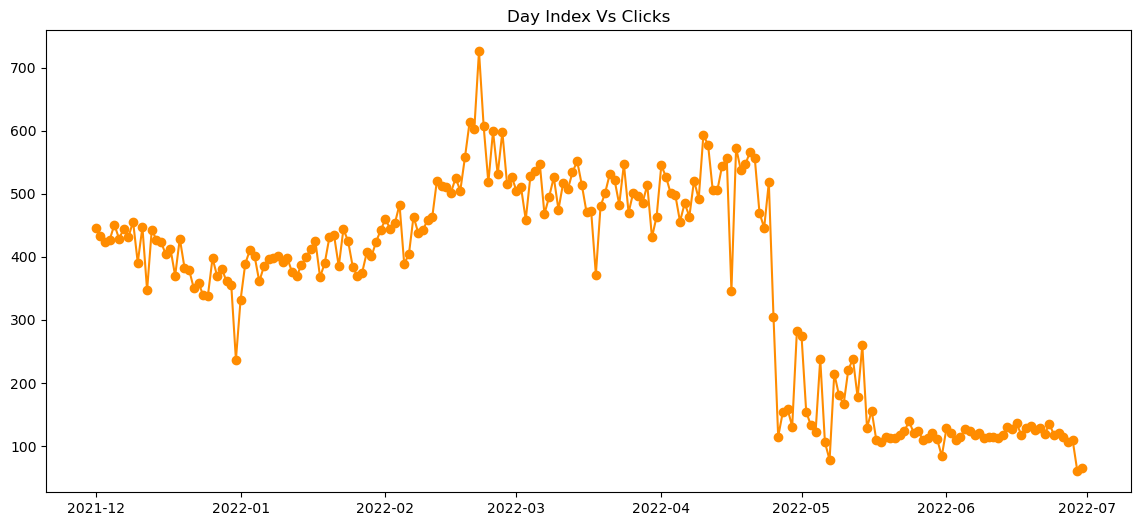

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(dataset['Day Index'],dataset['Clicks'],marker='o',c='darkorange')
plt.title("Day Index Vs Clicks")

    The plot shows a steady increase in clicks until may-2022, followed by a sharp decline.

### 7.Detecting Outliers

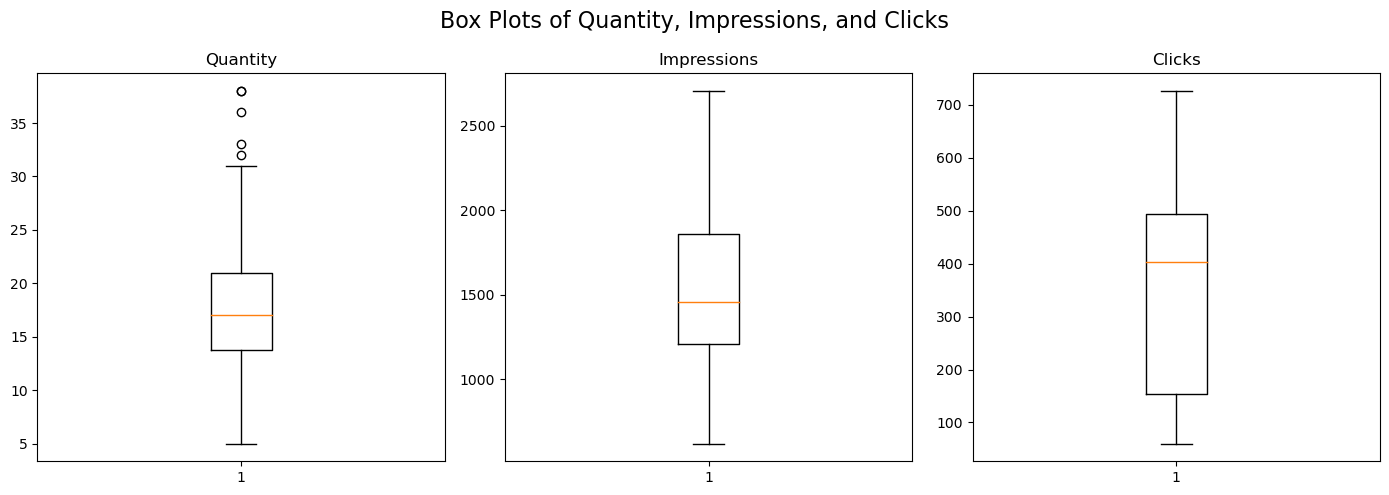

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].boxplot(dataset['Quantity'])
ax[0].set_title("Quantity")

ax[1].boxplot(dataset['Impressions'])
ax[1].set_title("Impressions")

ax[2].boxplot(dataset['Clicks'])
ax[2].set_title("Clicks")

fig.suptitle("Box Plots of Quantity, Impressions, and Clicks", fontsize=16)
plt.tight_layout()
plt.show()

     ➡️There are outliers only in Quantity attribute

### 8.Handling Outliers

In [15]:
def count_outliers(df):
    outlier_counts = {}
    for i in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[i] < lower_bound) | (df[i] > upper_bound)]
        outlier_counts[i] = len(outliers)
    return outlier_counts


outliers = count_outliers(dataset)
print("Number of outliers in each column\n")
for i in outliers:
    print(i," : ",outliers[i])

Number of outliers in each column

Quantity  :  5
Clicks  :  0
Impressions  :  0


In [16]:
percentile=dataset['Quantity'].quantile(0.95)
print("95th percentile value : ",percentile)

95th percentile value :  27.44999999999999


In [17]:
def update_outliers(data):
    q1,q3=data.quantile([0.25,0.75])
    IQR=q3-q1
    lower,upper=q1-(1.5*IQR), q3+(1.5*IQR)
    return data.apply(lambda x: percentile if x<lower or x>upper else x)

In [18]:
df=dataset.copy()
df['Quantity']=update_outliers(df['Quantity'])
print("Updated Data : ")
df

Updated Data : 


,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14.00,445,620
1,2021-12-02,10.00,433,890
2,2021-12-03,13.00,424,851
3,2021-12-04,22.00,427,881
4,2021-12-05,27.45,451,678
...,...,...,...,...
207,2022-06-26,13.00,114,1218
208,2022-06-27,16.00,106,1311
209,2022-06-28,13.00,109,885
210,2022-06-29,16.00,60,1000


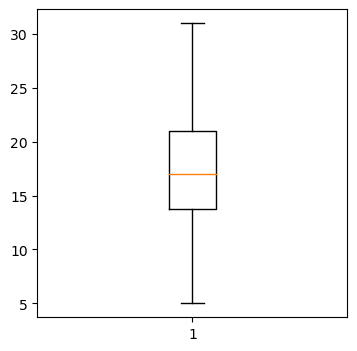

In [19]:
plt.figure(figsize=(4,4))
plt.boxplot(df['Quantity'])
plt.show()

    Therefore, Outliers are replaced by 95th percentile values.

# Feature Engineering

* Extracting year and month from Day Index

In [20]:
df['Year-Month'] = df['Day Index'].dt.to_period('M')

* Extracting Month names and Month number

In [21]:
df['MonthName'] = df['Day Index'].dt.month_name()
df['MonthName'] = pd.Categorical(df['MonthName'], categories=['December', 'January', 'February', 'March', 'April', 'May', 'June'], ordered=True)
df['MonthNumber'] = df['Day Index'].dt.month
# df.head()

* Extracting day of the week and No.of week in Month

In [22]:
df['Day_of_week'] = df['Day Index'].dt.day_name()
df['Day_of_week'] = pd.Categorical(df['Day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
df['Day_number'] = df['Day Index'].dt.weekday+1

def weekOfMonth(date):
    first_day = date.replace(day=1)
    date = date.day + first_day.weekday()
    return int(np.ceil(date/7.0))

df['Week_of_Month'] = df['Day Index'].apply(weekOfMonth)

* Checking whether a day is weekend or week day

In [23]:
df['Weekend'] = (df['Day Index'].dt.weekday > 4).astype(int)
# df['Week_day'] = (df['Day Index'].dt.weekday < 5).astype(int)

* Extracting months and adding to dataset

In [24]:
months=['December','January','February','March','April','May','June']
month_num=[12,1,2,3,4,5,6]
for i in range(len(months)):
    df[months[i]] = (df['MonthNumber'] == month_num[i]).astype(int)

df.head()

,Day Index,Quantity,Clicks,Impressions,Year-Month,MonthName,MonthNumber,Day_of_week,Day_number,Week_of_Month,Weekend,December,January,February,March,April,May,June
0,2021-12-01,14.00,445,620,2021-12,December,12,Wednesday,3,1,0,1,0,0,0,0,0,0
1,2021-12-02,10.00,433,890,2021-12,December,12,Thursday,4,1,0,1,0,0,0,0,0,0
2,2021-12-03,13.00,424,851,2021-12,December,12,Friday,5,1,0,1,0,0,0,0,0,0
3,2021-12-04,22.00,427,881,2021-12,December,12,Saturday,6,1,1,1,0,0,0,0,0,0
4,2021-12-05,27.45,451,678,2021-12,December,12,Sunday,7,1,1,1,0,0,0,0,0,0


<br></br>
* Extracting days and adding to dataset

In [25]:
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(len(days)):
    df[days[i]] = (df['Day_number']-1 == i).astype(int)

df.head()

,Day Index,Quantity,Clicks,Impressions,Year-Month,MonthName,MonthNumber,Day_of_week,Day_number,Week_of_Month,...,April,May,June,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2021-12-01,14.00,445,620,2021-12,December,12,Wednesday,3,1,...,0,0,0,0,0,1,0,0,0,0
1,2021-12-02,10.00,433,890,2021-12,December,12,Thursday,4,1,...,0,0,0,0,0,0,1,0,0,0
2,2021-12-03,13.00,424,851,2021-12,December,12,Friday,5,1,...,0,0,0,0,0,0,0,1,0,0
3,2021-12-04,22.00,427,881,2021-12,December,12,Saturday,6,1,...,0,0,0,0,0,0,0,0,1,0
4,2021-12-05,27.45,451,678,2021-12,December,12,Sunday,7,1,...,0,0,0,0,0,0,0,0,0,1


In [26]:
df.columns

Index(['Day Index', 'Quantity', 'Clicks', 'Impressions', 'Year-Month',
       'MonthName', 'MonthNumber', 'Day_of_week', 'Day_number',
       'Week_of_Month', 'Weekend', 'December', 'January', 'February', 'March',
       'April', 'May', 'June', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday'],
      dtype='object')

### 9.Corelation between Features

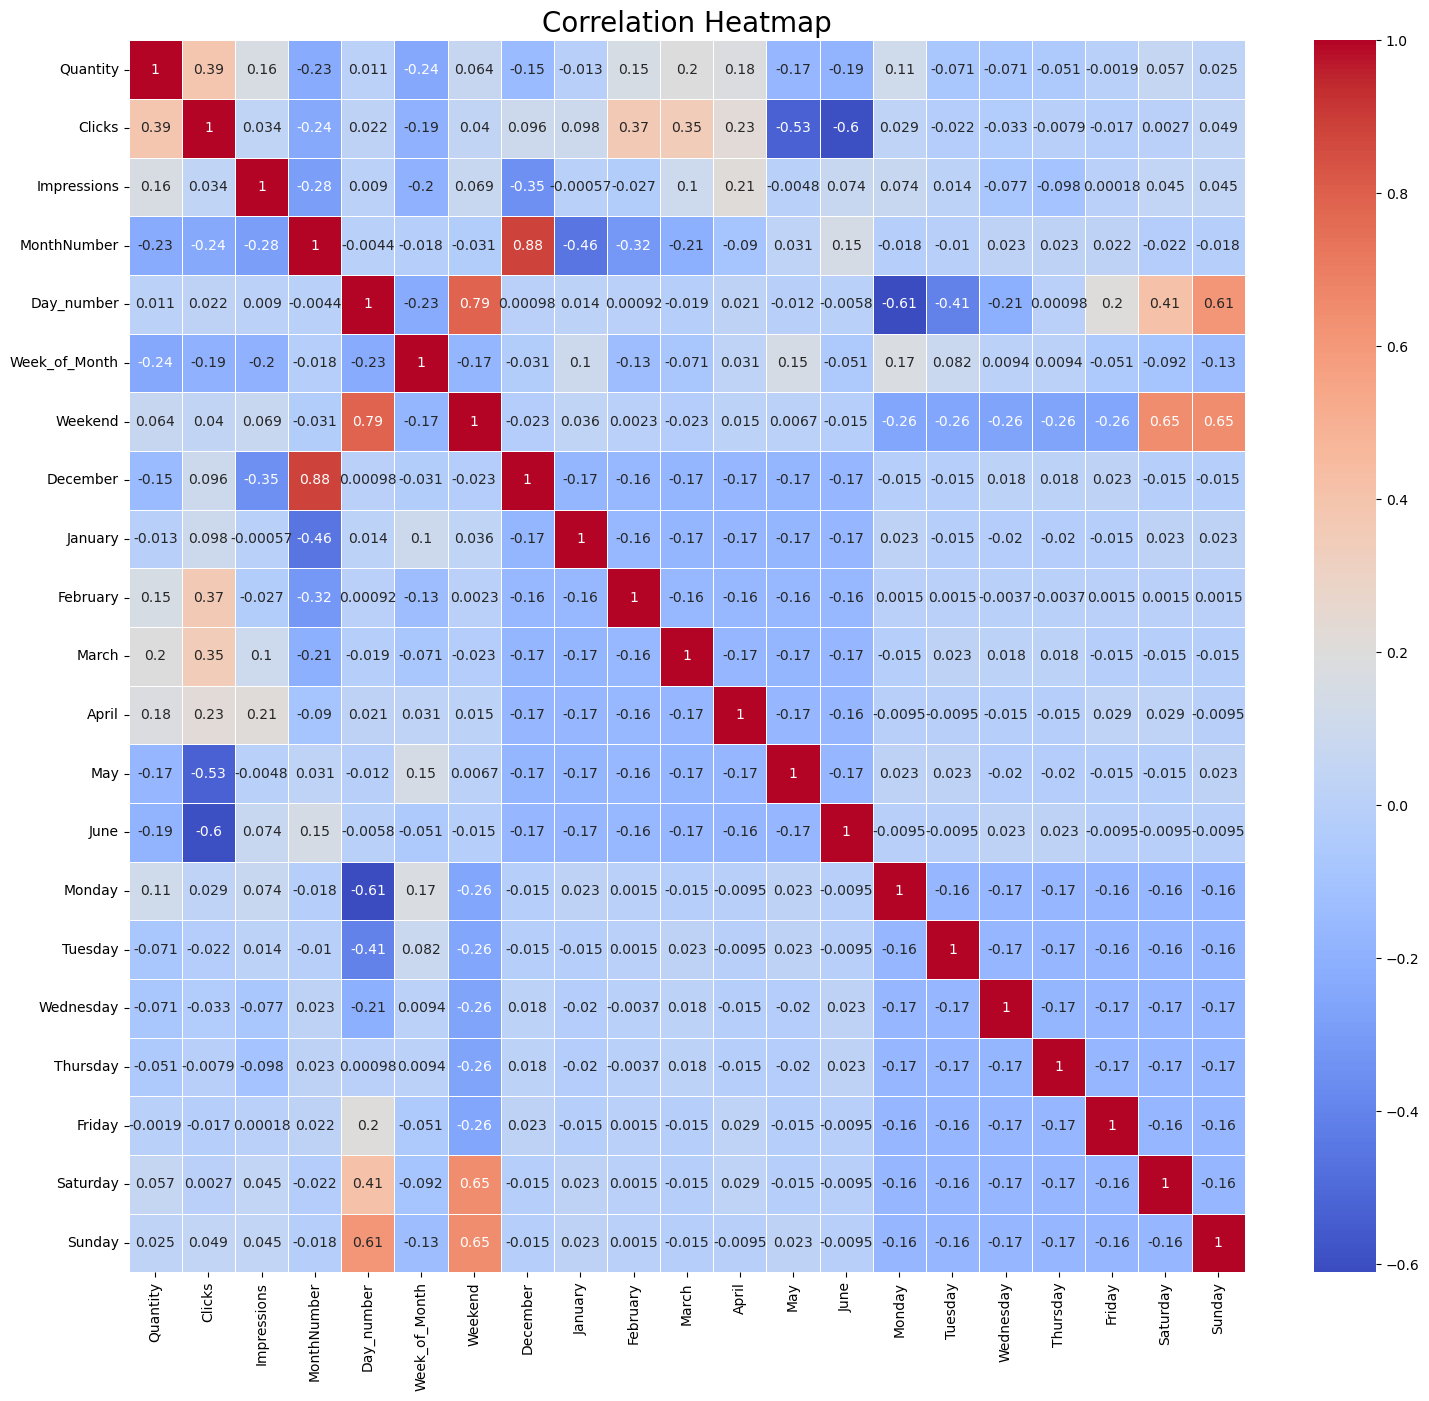

In [27]:
plt.figure(figsize=(18,16))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm",linewidths=0.5).set_title("Correlation Heatmap",fontsize=20)
plt.show()

    The heatmap shows a positive correlation between Quantity and Clicks

### Day wise plots

#### i. For Quantity

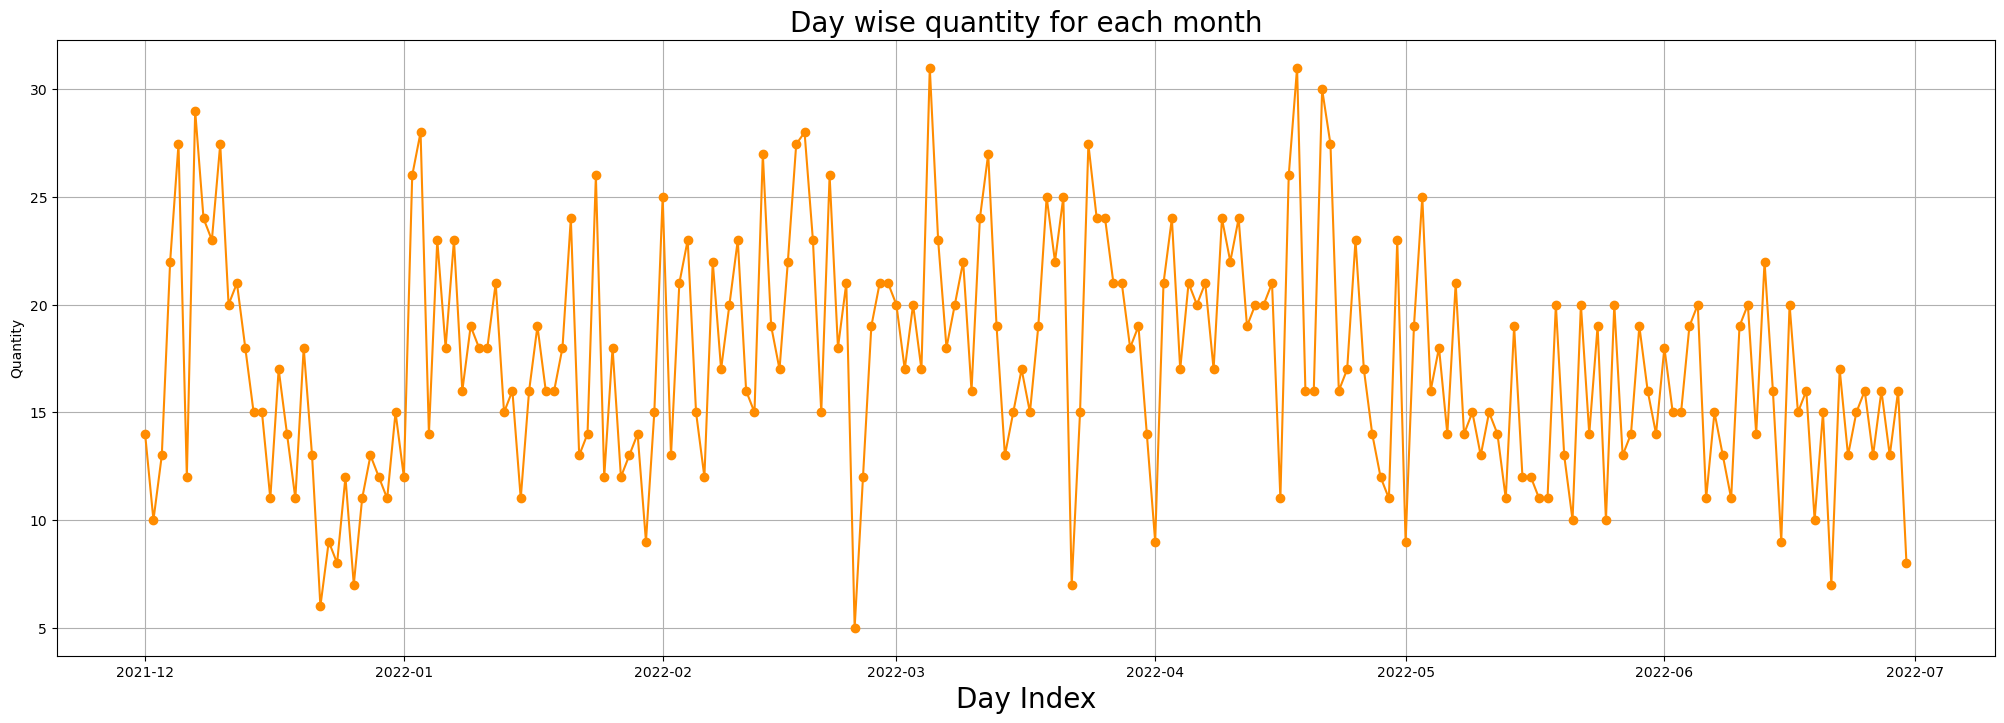

In [28]:
plt.figure(figsize=(25,8))
# plt.plot(dataset['Day Index'],dataset['Quantity'],color='purple')
plt.plot(df['Day Index'],df['Quantity'],marker='o',color='darkorange')
    
plt.title('Day wise quantity for each month',fontsize=20)
plt.xlabel('Day Index',fontsize=20)
plt.ylabel('Quantity')
plt.grid(True)
plt.show()  

    ➡️There are more sales in the months of December, March,April and May

#### ii. For Clicks

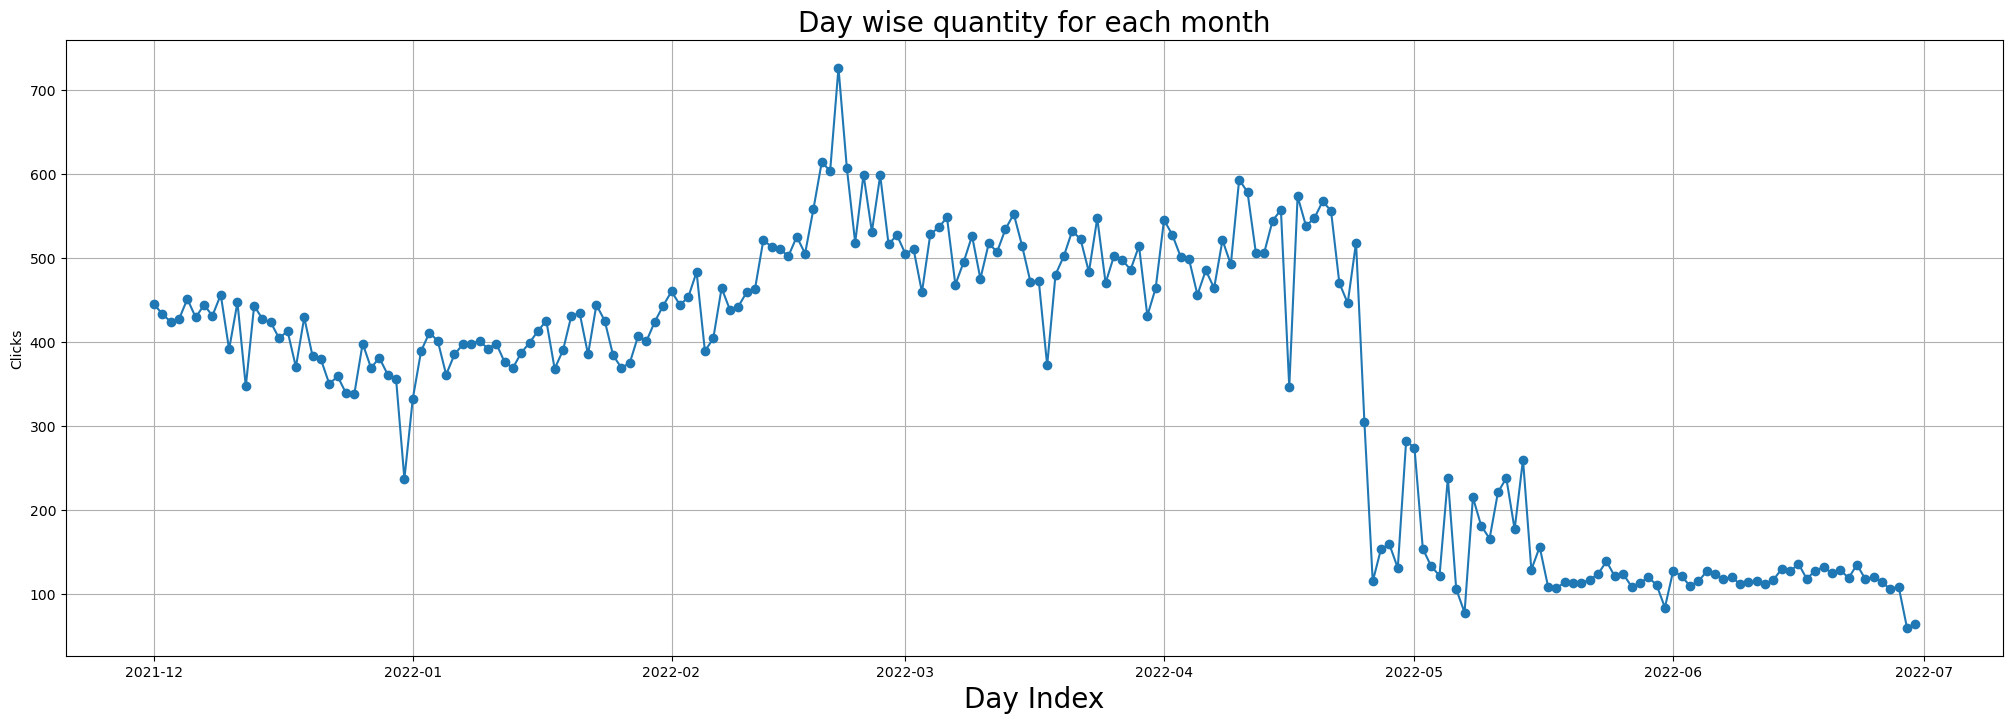

In [29]:
plt.figure(figsize=(25,8))

plt.plot(df['Day Index'],df['Clicks'],marker='o')
    
plt.title('Day wise quantity for each month',fontsize=20)
plt.xlabel('Day Index',fontsize=20)
plt.ylabel('Clicks')
plt.grid(True)
plt.show()

    ➡️There is steady increase in clicks until may-2022, followed by a sharp decline.

#### iii. For Impressions

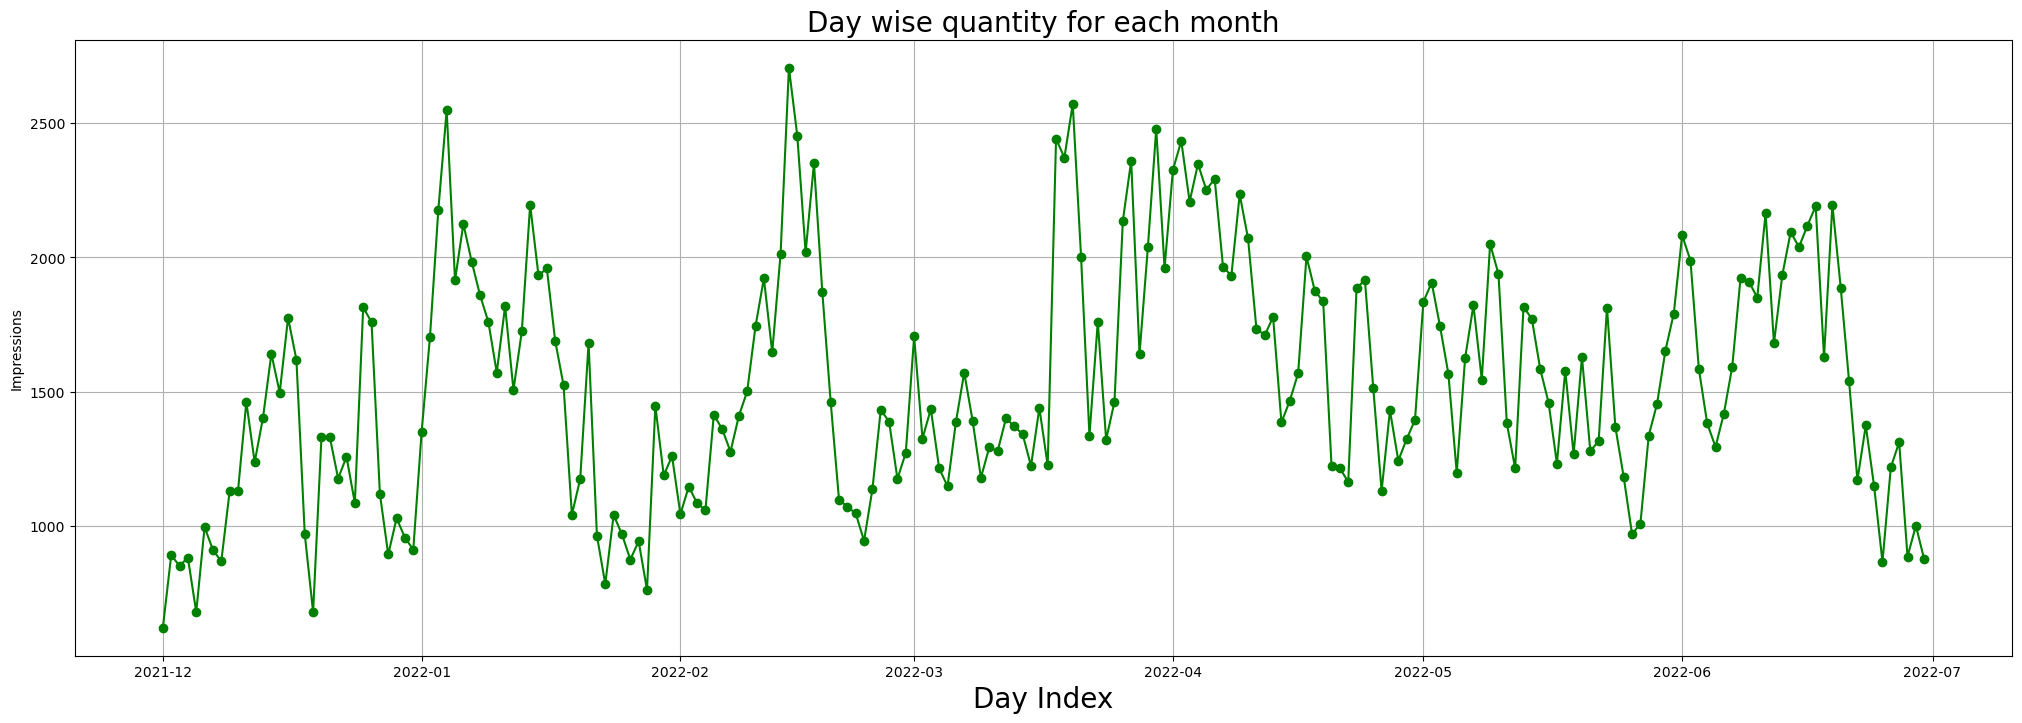

In [30]:
plt.figure(figsize=(25,8))
plt.plot(df['Day Index'],df['Impressions'],marker='o',c='g')
    
plt.title('Day wise quantity for each month',fontsize=20)
plt.xlabel('Day Index',fontsize=20)
plt.ylabel('Impressions')
plt.grid()
plt.show()  

    ➡️There are more peaks in the months of january and April. Highest impressions in February

### Analysing Monthly Data

In [31]:
monthly_data = df.groupby('Year-Month').agg({col: 'sum' for col in ['Quantity', 'Clicks', 'Impressions']}).reset_index()

monthly_data

,Year-Month,Quantity,Clicks,Impressions
0,2021-12,478.90,12284,35887
1,2022-01,533.00,12314,47464
2,2022-02,543.45,14372,42042
3,2022-03,615.45,15419,50803
4,2022-04,590.45,13480,52857
5,2022-05,471.00,4566,47325
6,2022-06,447.00,3504,48343


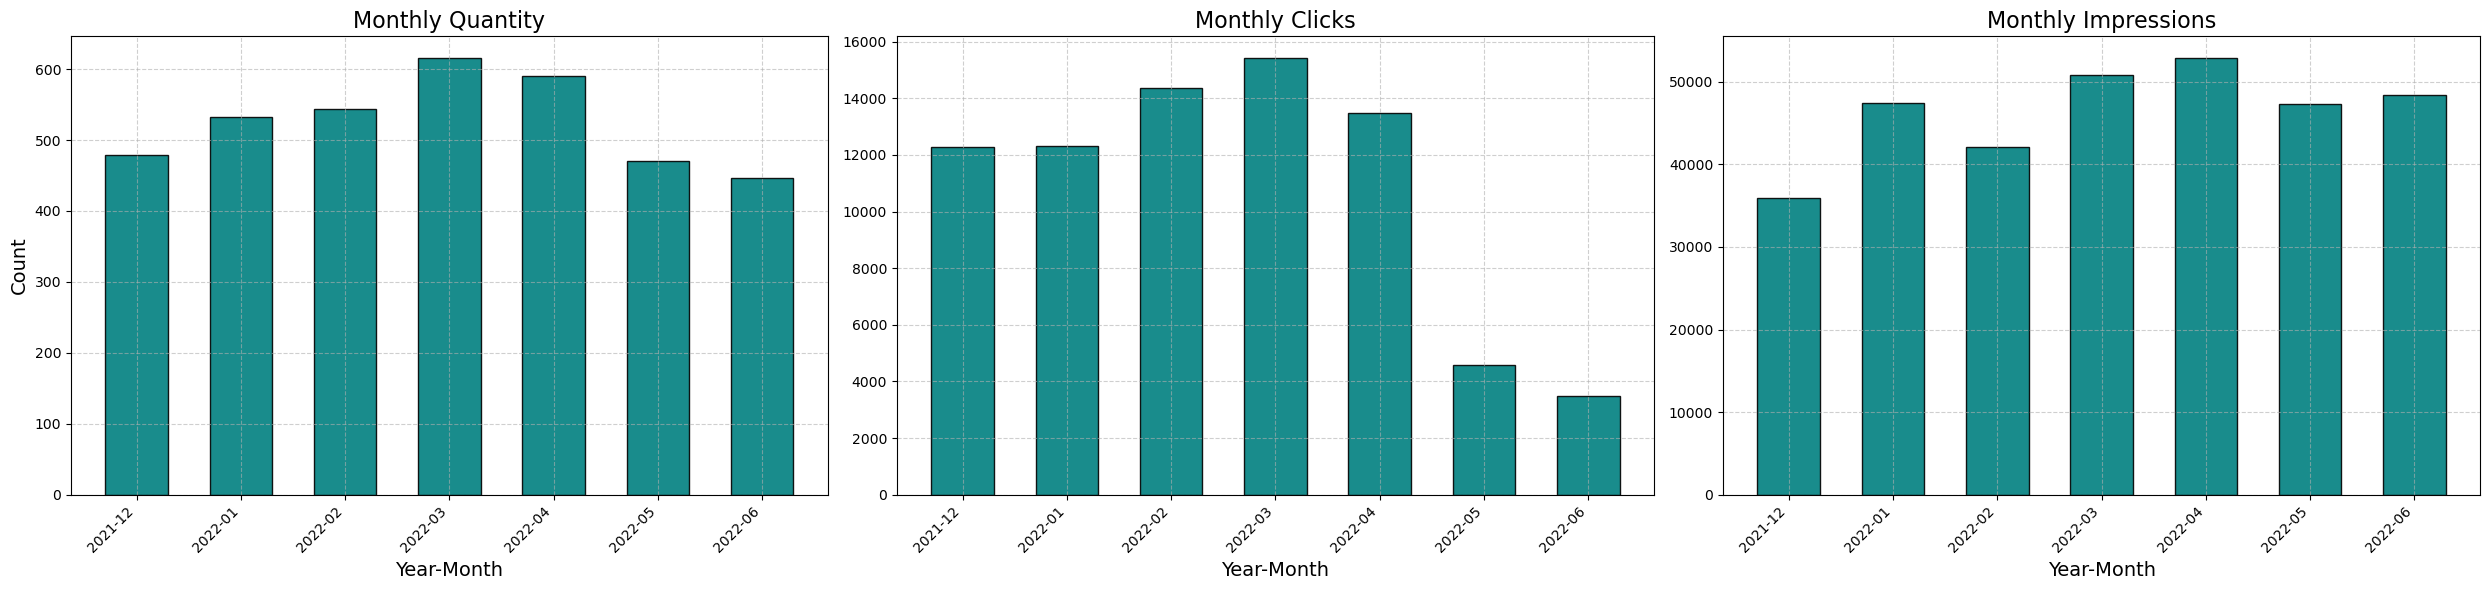

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharey=False)

monthly_data['Year-Month'] = monthly_data['Year-Month'].astype(str)
columns = ['Quantity', 'Clicks', 'Impressions']
titles = ['Monthly Quantity', 'Monthly Clicks', 'Monthly Impressions']

for i, col in enumerate(columns):
    axes[i].bar(monthly_data['Year-Month'], monthly_data[col], color='teal', edgecolor='black', alpha=0.9, width=0.6)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel('Year-Month', fontsize=14)
    axes[i].set_xticks(range(len(monthly_data['Year-Month'])))
    axes[i].set_xticklabels(monthly_data['Year-Month'], rotation=45, ha='right', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('Count', fontsize=14)

plt.tight_layout()
plt.show()


    ➡️Quantity, Clicks and Impressions are high in the month of March

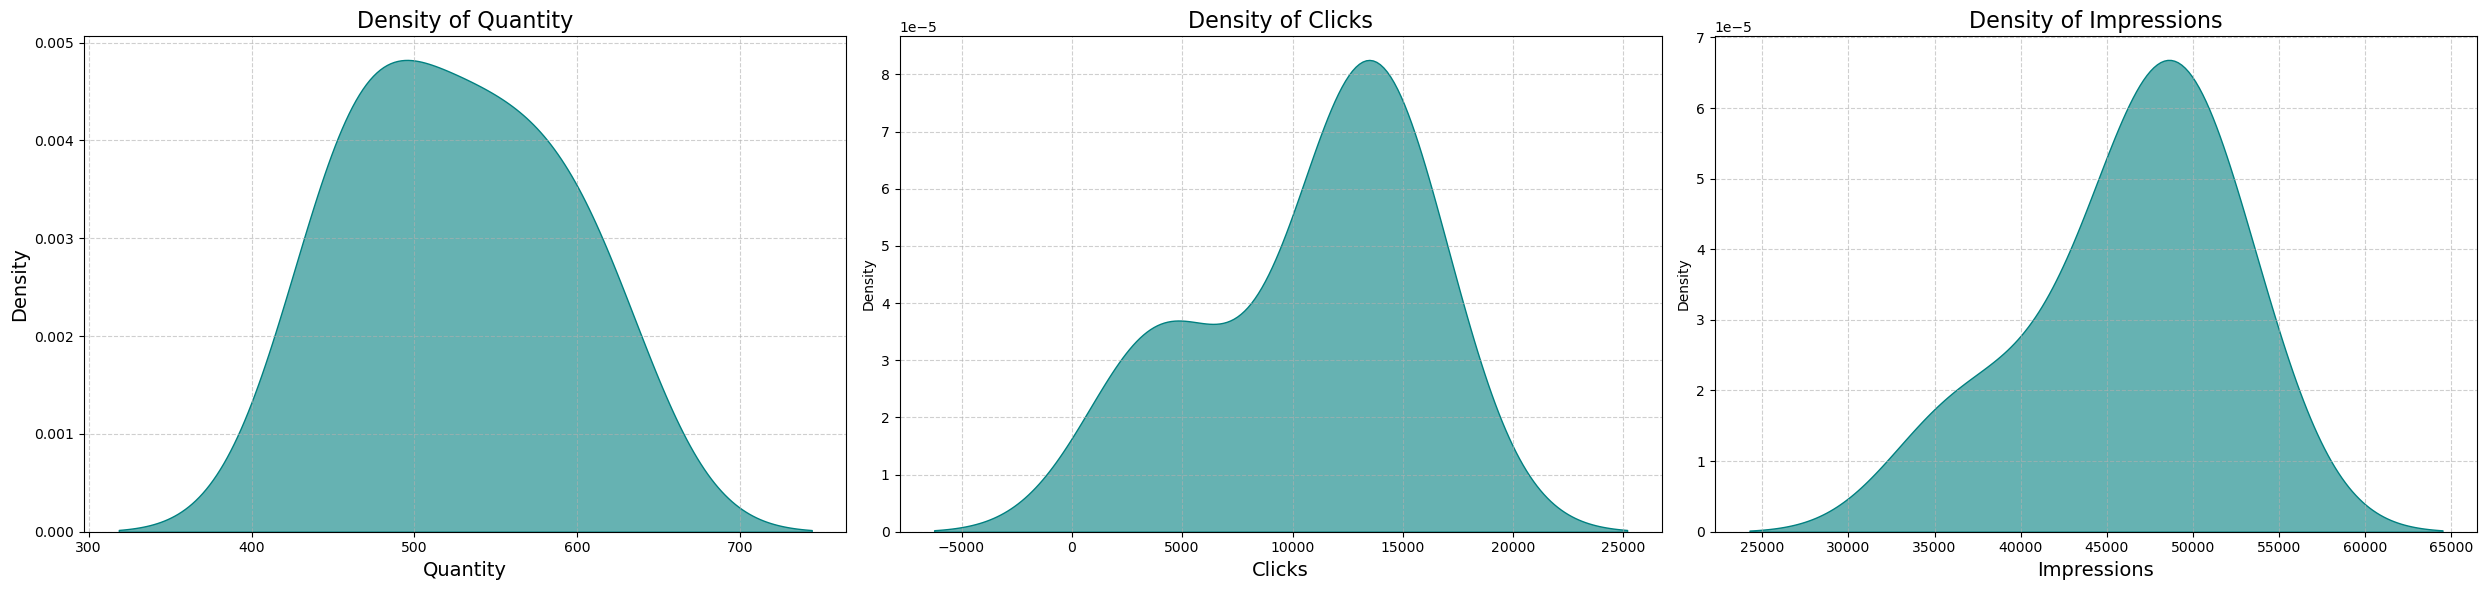

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharey=False)

columns = ['Quantity', 'Clicks', 'Impressions']
titles = ['Density of Quantity', 'Density of Clicks', 'Density of Impressions']

for i, col in enumerate(columns):
    sns.kdeplot(monthly_data[col], ax=axes[i], fill=True, color='teal', alpha=0.6)
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('Density', fontsize=14)

plt.tight_layout()
plt.show()


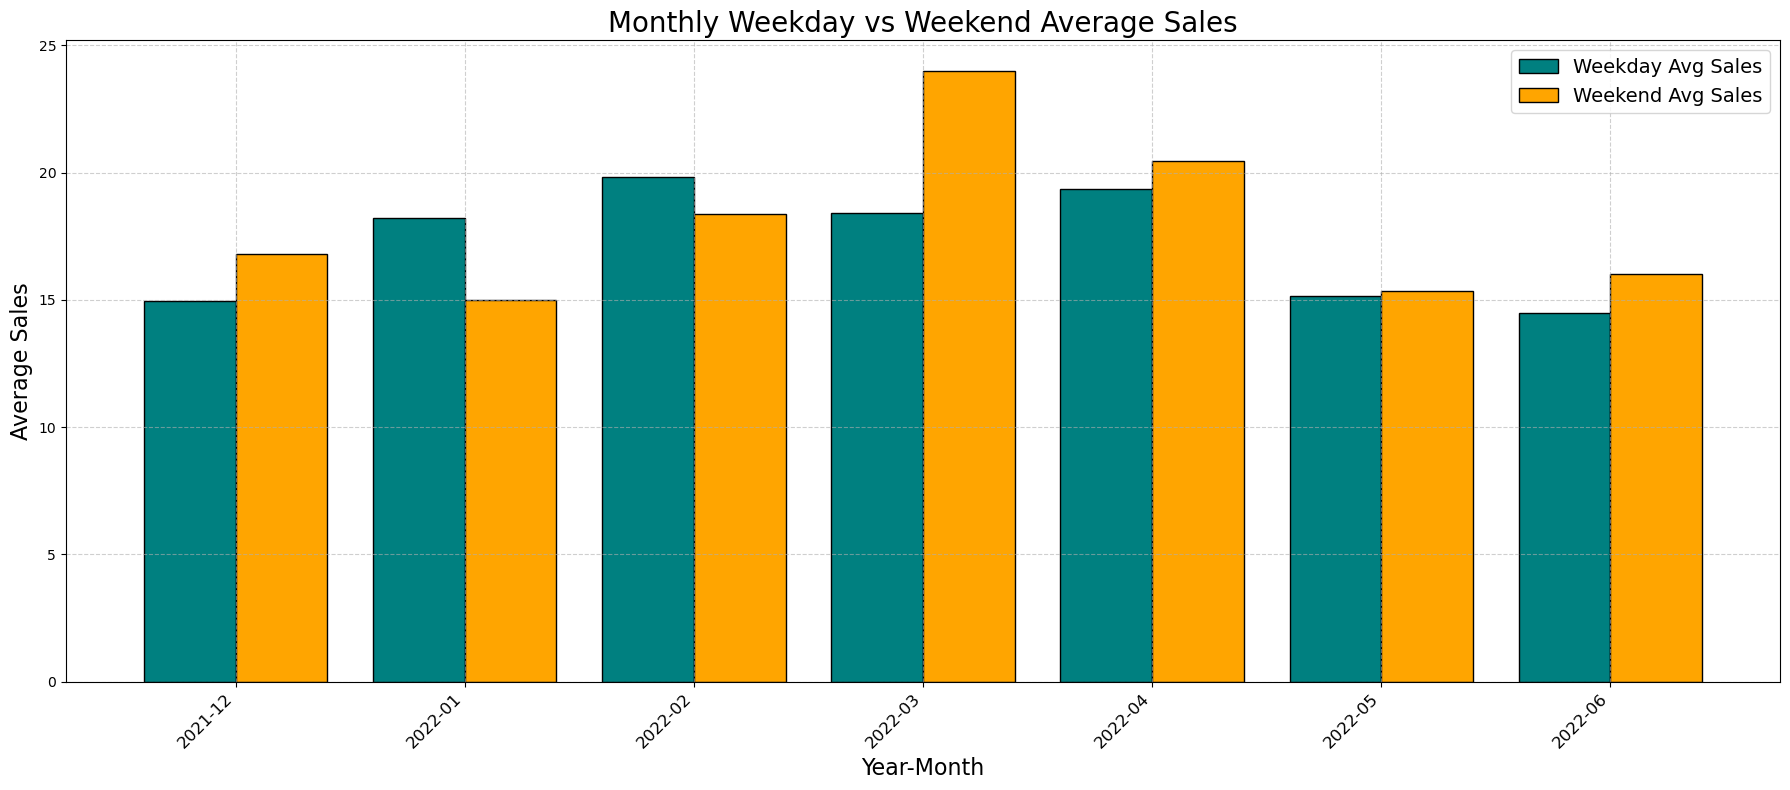

In [34]:
import matplotlib.pyplot as plt
import numpy as np

avg_sales = df.groupby(['Year-Month', 'Weekend'])['Quantity'].mean().unstack()

fig, ax = plt.subplots(figsize=(18, 8))
x_positions = np.arange(len(avg_sales))
bar_width = 0.4

ax.bar(x_positions - bar_width / 2, avg_sales[0], width=bar_width, label='Weekday Avg Sales', color='teal', edgecolor='black')
ax.bar(x_positions + bar_width / 2, avg_sales[1], width=bar_width, label='Weekend Avg Sales', color='orange', edgecolor='black')

ax.set_title('Monthly Weekday vs Weekend Average Sales', fontsize=20)
ax.set_xlabel('Year-Month', fontsize=16)
ax.set_ylabel('Average Sales', fontsize=16)
ax.set_xticks(x_positions)
ax.set_xticklabels(avg_sales.index, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


    ➡️Weekend average sales are more in 5 out of 7 months

### Day wise Analysis

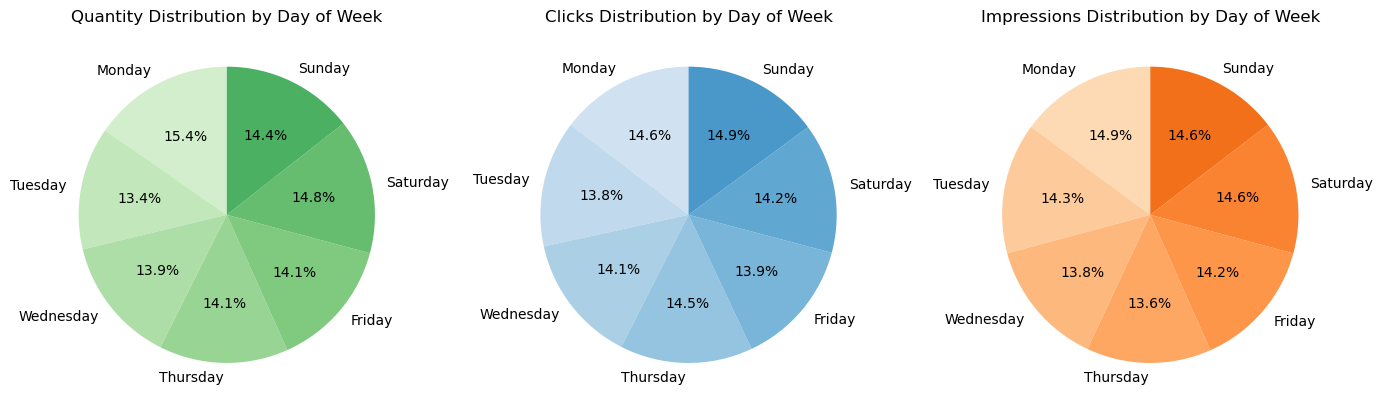

In [35]:
daywise_summary = df.groupby('Day_of_week').agg({
    'Quantity': 'sum',
    'Clicks': 'sum',
    'Impressions': 'sum'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(14, 6))

green_colors = plt.cm.Greens(np.linspace(0.2, 0.6, len(daywise_summary)))
axes[0].pie(daywise_summary['Quantity'], labels=daywise_summary['Day_of_week'], autopct='%1.1f%%', startangle=90, colors=green_colors)
axes[0].set_title('Quantity Distribution by Day of Week')

blues_colors = plt.cm.Blues(np.linspace(0.2, 0.6, len(daywise_summary)))
axes[1].pie(daywise_summary['Clicks'], labels=daywise_summary['Day_of_week'], autopct='%1.1f%%', startangle=90, colors=blues_colors)
axes[1].set_title('Clicks Distribution by Day of Week')

orange_colors = plt.cm.Oranges(np.linspace(0.2, 0.6, len(daywise_summary)))
axes[2].pie(daywise_summary['Impressions'], labels=daywise_summary['Day_of_week'], autopct='%1.1f%%', startangle=90, colors=orange_colors)
axes[2].set_title('Impressions Distribution by Day of Week')

plt.tight_layout()
plt.show()

➡️Highest number of Sales on Monday<br>
➡️Highest number of Clicks on Sunday<br>
➡️Highest number of Impressions on Monday

## Week -3

## TIME SERIES MODELLING

### 10.Statistical Tests for Stationarity

In [36]:
#Augmented Dickey-Fuller (ADF) test

adftest = adfuller(df['Quantity'])
print('1. Test Statistic : ',adftest[0])
print('2. P-value: ',adftest[1])
print('3. Number of Lags : ',adftest[2])
print('4. Number of Observations used : ',adftest[3])
print('5. Critical values : ')

for i in adftest[4]:
    print("\t",i," : ",adftest[4][i])

if adftest[1] <= 0.05:
    print('\nReject the null hypothesis: The time series is stationary.')
else:
    print('Fail to reject the null hypothesis: The time series is non-stationary.')

1. Test Statistic :  -4.367385682143468
2. P-value:  0.0003388676203418857
3. Number of Lags :  3
4. Number of Observations used :  208
5. Critical values : 
	 1%  :  -3.4621857592784546
	 5%  :  -2.875537986778846
	 10%  :  -2.574231080806213

Reject the null hypothesis: The time series is stationary.


In [37]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
kpss_result = kpss(df['Quantity'])

print(f'Test Statistic: {kpss_result[0]}')
print(f'P-value: {kpss_result[1]}')
print(f'Number of Lags: {kpss_result[2]}')
print('Critical Values:')
for i in kpss_result[3]:
    print("\t",i," : ",kpss_result[3][i])
# Interpretation of the result
if kpss_result[1] > 0.05:
    print('\nFail to reject the null hypothesis: The time series is stationary.')
else:
    print('\nReject the null hypothesis: The time series is non-stationary.')


Test Statistic: 0.3377878133107644
P-value: 0.1
Number of Lags: 7
Critical Values:
	 10%  :  0.347
	 5%  :  0.463
	 2.5%  :  0.574
	 1%  :  0.739

Fail to reject the null hypothesis: The time series is stationary.


C:\Users\BHAVAJNA\AppData\Local\Temp\ipykernel_2628\45979898.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['Quantity'])


### 11. Check for Autocorrelation

<Figure size 1000x600 with 0 Axes>

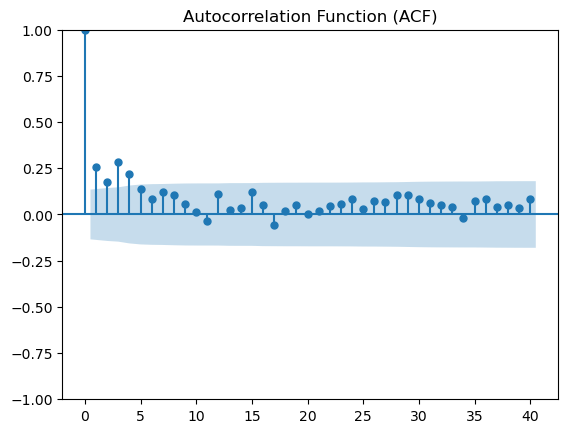

In [38]:
# Autocorrelation Function
plt.figure(figsize=(10, 6))
plot_acf(df['Quantity'], lags=40, alpha=0.05)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

- ***Significant spike at lag 1***:
    The ACF shows a strong positive spike at lag 1, which suggests immediate autocorrelation in the data.<br></br>
    
- ***Gradual decay in subsequent lags***:
    The spikes decay over a few lags and eventually fall within the confidence interval. This behavior could indicate a short-term dependency in the data but not a persistent long-term correlation.<br></br>

- ***Some minor spikes beyond lag 1***:
    There are small spikes that exceed the confidence interval at lags 2, 3, and possibly a few more, suggesting potential noise or short-lived MA (Moving Average) effects.


<Figure size 1000x600 with 0 Axes>

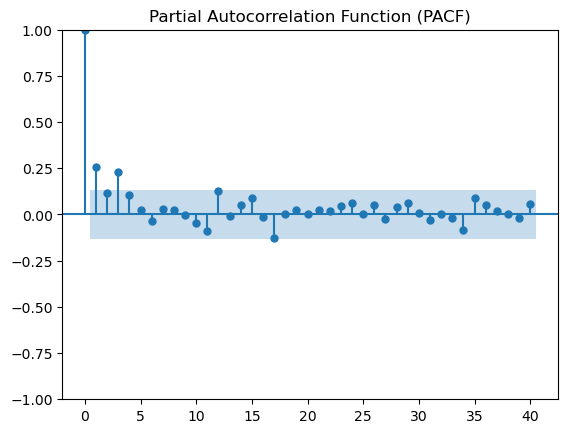

In [39]:
# Partial Autocorrelation Function
plt.figure(figsize=(10, 6))
plot_pacf(df['Quantity'], lags=40, alpha=0.05, method='ywm')  # Use method='ywm' for improved accuracy
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

- **Strong spike at lag 1**: The PACF shows a significant positive spike at lag 1, which exceeds the confidence interval.This indicates that the immediate past value (lag 1) has a strong influence on the current value.<br></br>

- **Subsequent lags**:After lag 1, most spikes fall within the confidence interval, indicating that higher-order lags do not have a significant partial correlation with the series.

### 12. Train - test split

In [40]:
train_size = int(len(df) * 0.7)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

y_train=train_data['Quantity']
y_test=test_data['Quantity']
y_dates=test_data['Day Index']
X_train=train_data.iloc[:,2:]
X_test=test_data.iloc[:,2:]

X_train=X_train.drop(['Year-Month','MonthName','Day_of_week'],axis=1)
X_test=X_test.drop(['Year-Month','MonthName','Day_of_week'],axis=1)
print(y_train)
# print(test_data)

0      14.00
1      10.00
2      13.00
3      22.00
4      27.45
       ...  
143    16.00
144    17.00
145    23.00
146    17.00
147    14.00
Name: Quantity, Length: 148, dtype: float64


## Auto Regression Model (AR)

In [41]:
model = AutoReg(y_train,lags=1)  # lags=1 means AR(1) model
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
# print(f"Forecasted values: {forecast}")

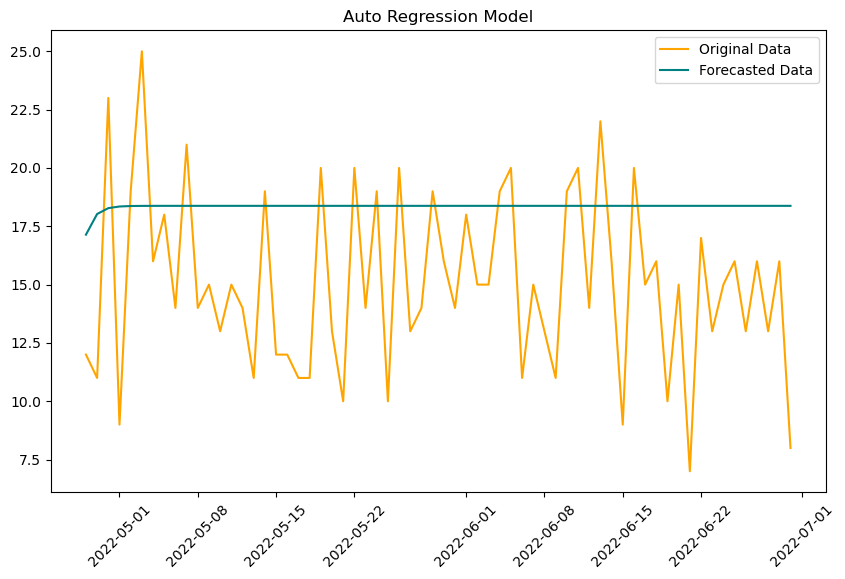

In [42]:
def plot_graph(model,forecast):
    plt.figure(figsize=(10, 6))

    # Plot the original data
    plt.plot(y_dates,y_test, label='Original Data', color='orange')

    # Plot the forecasted values
    plt.plot(y_dates, forecast, label='Forecasted Data', color='teal')
    plt.title(model)
    plt.xticks(rotation=45)
    plt.legend()
    
plot_graph("Auto Regression Model",forecast)

In [43]:
best_lag = None
best_mse = float("inf")

# Try different lag values
for lag in range(1, 20):  # Adjust range as needed
    model = AutoReg(y_train, lags=lag)
    model_fitted = model.fit()
    
    # Generate forecast
    forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, forecast)
    if mse < best_mse:
        best_mse = mse
        best_lag = lag

print(f"Optimal lag: {best_lag}, Best MSE: {best_mse}")

Optimal lag: 12, Best MSE: 23.69597510934166


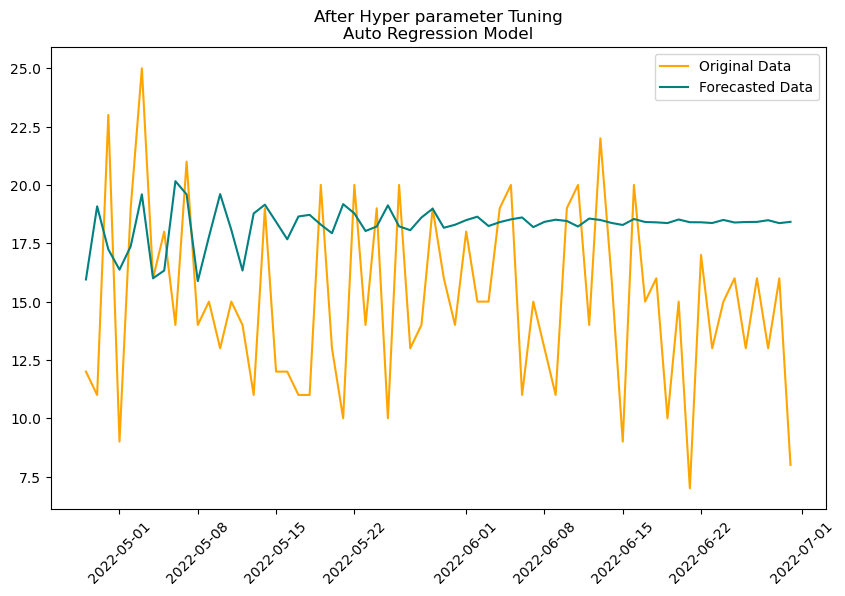

In [44]:
plot_graph("After Hyper parameter Tuning\nAuto Regression Model",forecast)

- Forecasted data appears relatively static, indicating poor adaptability to variations.

In [45]:
def metrics(model,forecast):
    mae = mean_absolute_error(y_test, forecast)
    mse = mean_squared_error(y_test,forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    return [model,mae,mse,rmse,mape]
    
AR = metrics("AR",forecast)

Mean Absolute Error (MAE): 4.170280958792282
Mean Squared Error (MSE): 25.306673118416214
Root Mean Squared Error (RMSE): 5.0305738358974725
Mean Absolute Percentage Error (MAPE): 34.58%


## Moving Average Model(MA)

In [46]:
model = ARIMA(y_train, order=(0, 0, 1))
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
print(forecast)

148    17.311237
149    18.334687
150    18.334687
151    18.334687
152    18.334687
         ...    
207    18.334687
208    18.334687
209    18.334687
210    18.334687
211    18.334687
Name: predicted_mean, Length: 64, dtype: float64


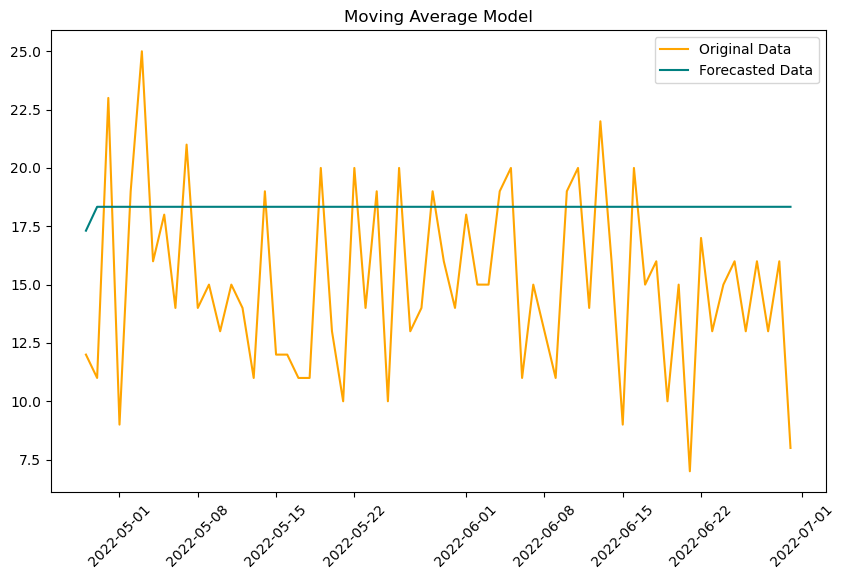

In [47]:
plot_graph("Moving Average Model",forecast)

In [48]:
MA = metrics("MA",forecast)

Mean Absolute Error (MAE): 4.245102320637361
Mean Squared Error (MSE): 25.235819780989964
Root Mean Squared Error (RMSE): 5.02352662787707
Mean Absolute Percentage Error (MAPE): 35.02%


In [49]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_order = None
best_mse = float("inf")
best_forecast = None

# Grid search for best (p, d, q)
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Train ARIMA model
                model = ARIMA(y_train, order=(p, d, q))
                model_fitted = model.fit()
                
                # Generate forecast
                forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                
                # Evaluate performance
                mse = mean_squared_error(y_test, forecast)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
                    best_forecast = forecast
            except:
                continue

print(f"Best order: {best_order}, Best MSE: {best_mse}")

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best order: (1, 1, 0), Best MSE: 14.772054459290192


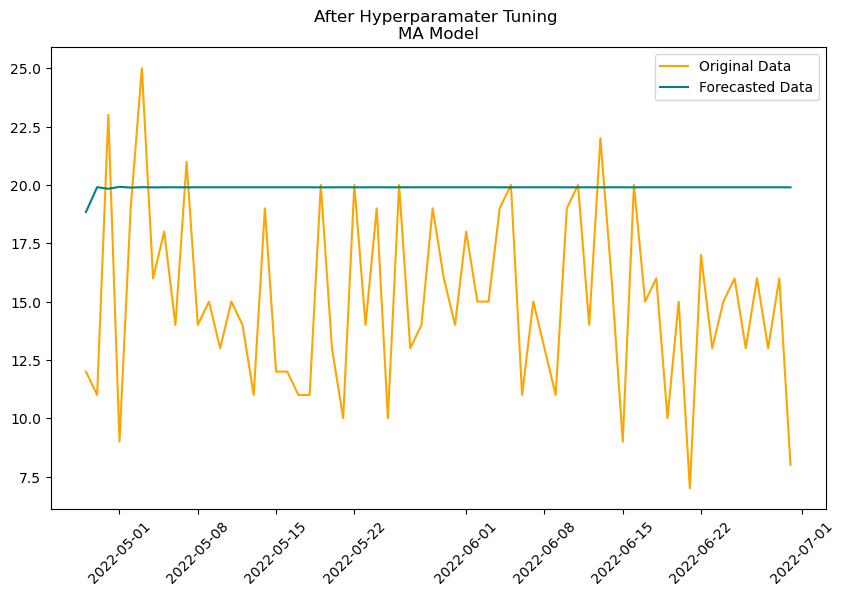

In [50]:
plot_graph("After Hyperparamater Tuning \nMA Model",forecast)

## ARIMA Model

In [51]:
p,d,q = 1,0,3
model = ARIMA(y_train, order=(p,d,q))
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
print(forecast)

148    17.900348
149    17.934699
150    17.302134
151    17.593480
152    17.794921
         ...    
207    18.246275
208    18.246275
209    18.246275
210    18.246275
211    18.246275
Name: predicted_mean, Length: 64, dtype: float64


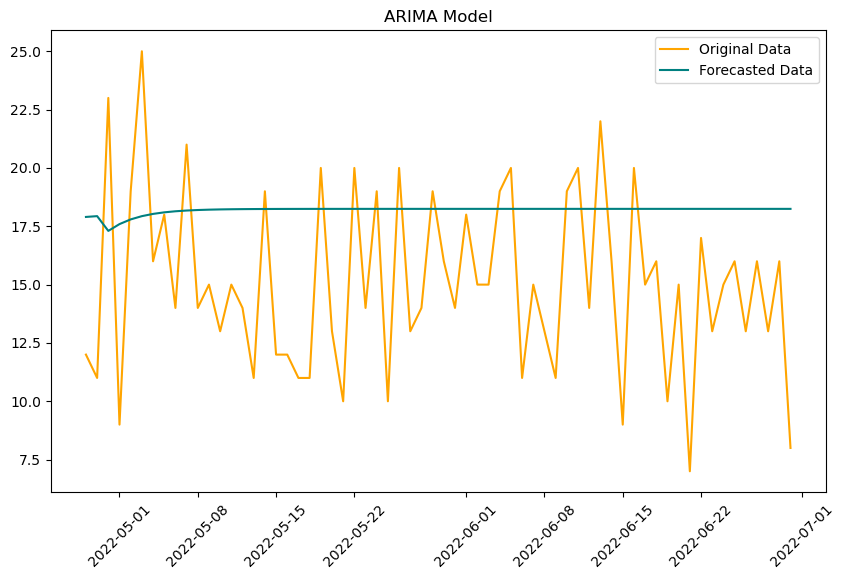

In [52]:
plot_graph("ARIMA Model",forecast)

In [53]:
p_values = range(0, 4)  # Test p = 0, 1, 2, 3
d_values = range(0, 2)  # Test d = 0, 1
q_values = range(0, 4)  # Test q = 0, 1, 2, 3

best_order = None
best_mse = float("inf")
best_forecast = None

# Grid search over (p, d, q)
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit ARIMA model
                model = ARIMA(y_train, order=(p, d, q))
                model_fitted = model.fit()
                
                # Generate forecast
                forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                
                # Calculate MSE
                mse = mean_squared_error(y_test, forecast)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
                    best_forecast = forecast
            except:
                continue

# Print the best parameters and MSE
print(f"Best ARIMA Order: {best_order}, Best MSE: {best_mse}")

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3

Best ARIMA Order: (1, 1, 0), Best MSE: 14.772054459290192


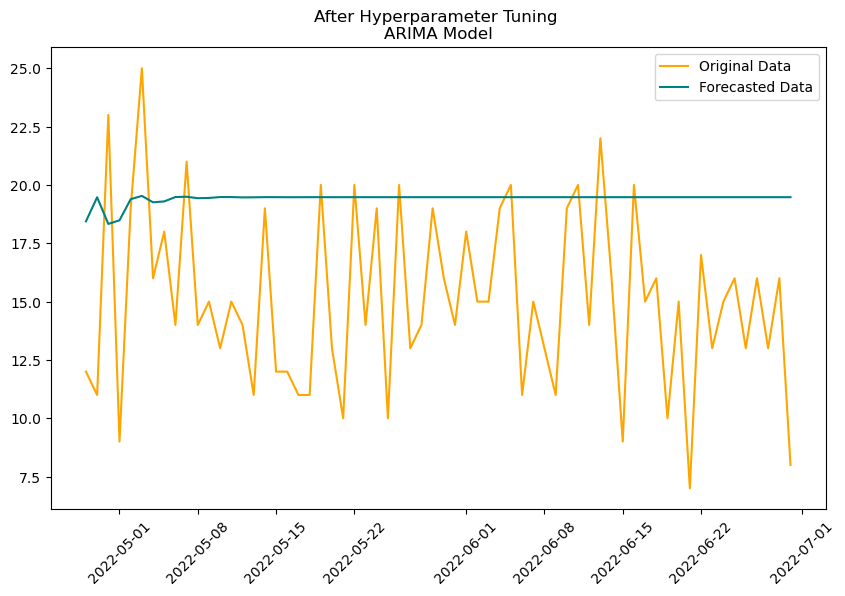

In [54]:
plot_graph("After Hyperparameter Tuning \nARIMA Model",forecast)

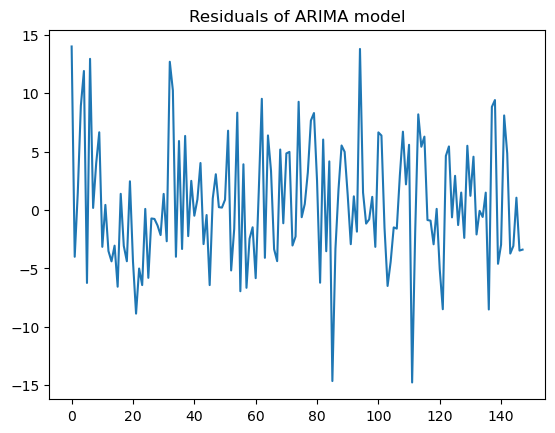

In [55]:
# Plot residuals
residuals = model_fitted.resid
plt.plot(residuals)
plt.title("Residuals of ARIMA model")
plt.show()

In [56]:
ARIMA = metrics("ARIMA",forecast)

Mean Absolute Error (MAE): 4.897090244165117
Mean Squared Error (MSE): 33.74816480601287
Root Mean Squared Error (RMSE): 5.80931706881393
Mean Absolute Percentage Error (MAPE): 40.64%


## SARIMA Model

In [57]:
model = SARIMAX(y_train, order=(1,0,3), seasonal_order=(1, 1, 1, 12))
model_fitted = model.fit()

forecast = model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
print(forecast)

148    17.589278
149    22.271315
150    21.873771
151    17.926952
152    18.076903
         ...    
207    17.114792
208    16.754955
209    22.746545
210    23.041209
211    18.173677
Name: predicted_mean, Length: 64, dtype: float64


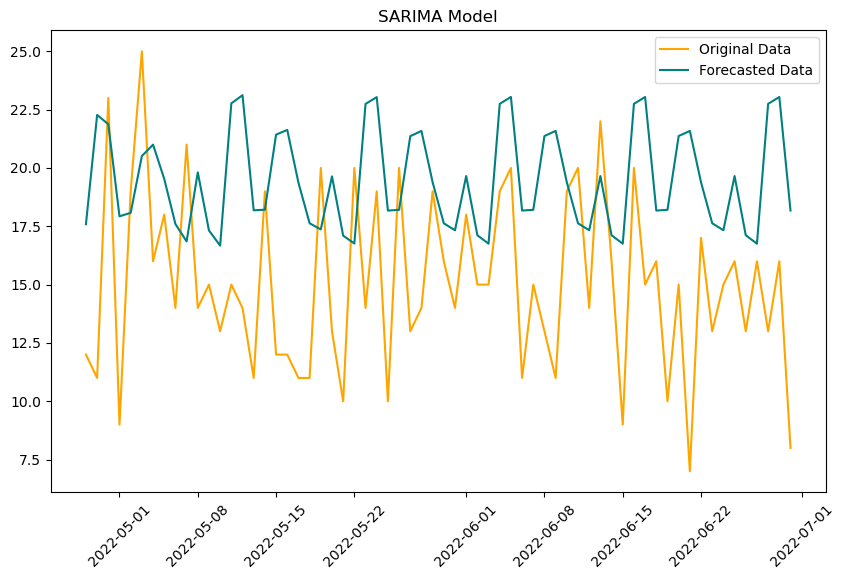

In [58]:
plot_graph("SARIMA Model",forecast)

In [59]:
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
p, d, q = range(1,3), range(2), range(1,3)
P, D, Q, s = range(1), range(1), range(3), 12

best_order, best_seasonal, best_mse = None, None, float("inf")
for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
                        try:
                            model = SARIMAX(y_train, order=(i, j, k), seasonal_order=(I, J, K, s)).fit(disp=False)
                            forecast = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                            mse = mean_squared_error(y_test, forecast)
                            if mse < best_mse:
                                best_mse, best_order, best_seasonal, best_forecast = mse, (i, j, k), (I, J, K, s), forecast
                        except:
                            continue

print(f"Best Order: {best_order}, Seasonal: {best_seasonal}, MSE: {best_mse}")

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Best Order: (1, 0, 1), Seasonal: (0, 0, 0, 12), MSE: 22.70980665172904


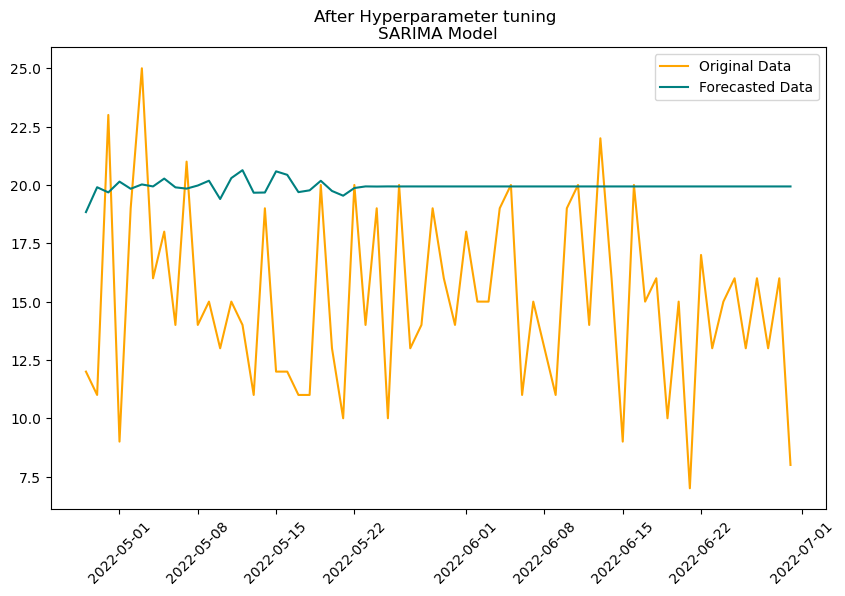

In [60]:
plot_graph("After Hyperparameter tuning \nSARIMA Model",forecast)

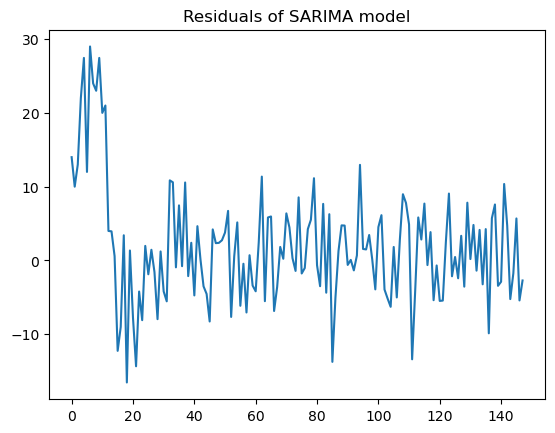

In [61]:
# Plot residuals
residuals = model_fitted.resid
plt.plot(residuals)
plt.title("Residuals of SARIMA model")
plt.show()

In [62]:
SARIMA = metrics("SARIMA",forecast)

Mean Absolute Error (MAE): 5.239136243283134
Mean Squared Error (MSE): 38.366775898174524
Root Mean Squared Error (RMSE): 6.194092015636716
Mean Absolute Percentage Error (MAPE): 43.48%


## ARIMAX Model

In [63]:
model = SARIMAX(y_train, exog=X_train, order=(1,0,3))
model_fitted = model.fit()

forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)
# print(model_fitted.summary())
print(forecast)

148    13.320488
149    14.643686
150    15.678299
151    16.080567
152    15.676215
         ...    
207    11.069511
208    12.268535
209     8.902202
210     8.895502
211     8.558343
Name: predicted_mean, Length: 64, dtype: float64


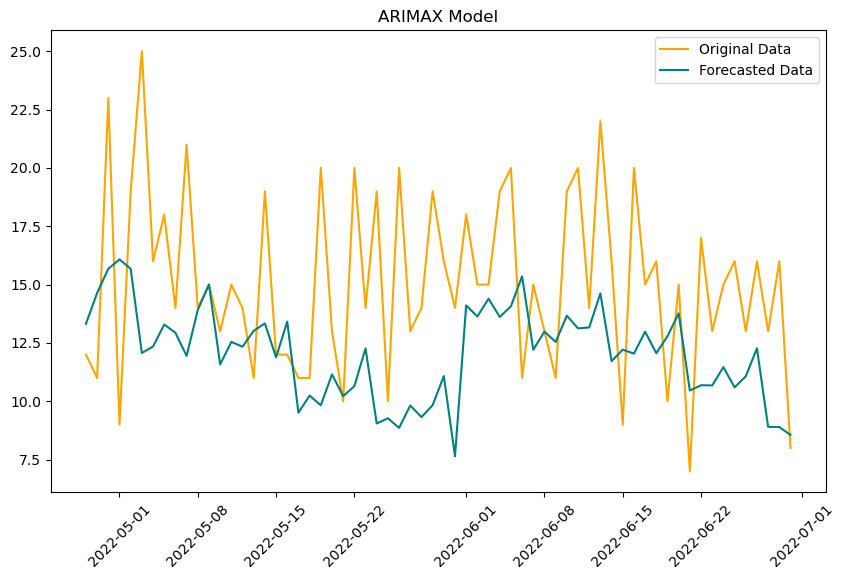

In [64]:
plot_graph("ARIMAX Model",forecast)

In [65]:
p, d, q = range(3), range(2), range(3)

best_order, best_mse, best_forecast = None, float("inf"), None

# Grid search for (p, d, q)
for i in p:
    for j in d:
        for k in q:
            try:
                model = SARIMAX(y_train, exog=X_train, order=(i, j, k))
                model_fitted = model.fit(disp=False)
                forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)
                mse = mean_squared_error(y_test, forecast)
                if mse < best_mse:
                    best_mse, best_order, best_forecast = mse, (i, j, k), forecast
            except:
                continue

print(f"Best Order: {best_order}, Best MSE: {best_mse}")

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: Convergence

Best Order: (2, 1, 2), Best MSE: 15.614978604804143


C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


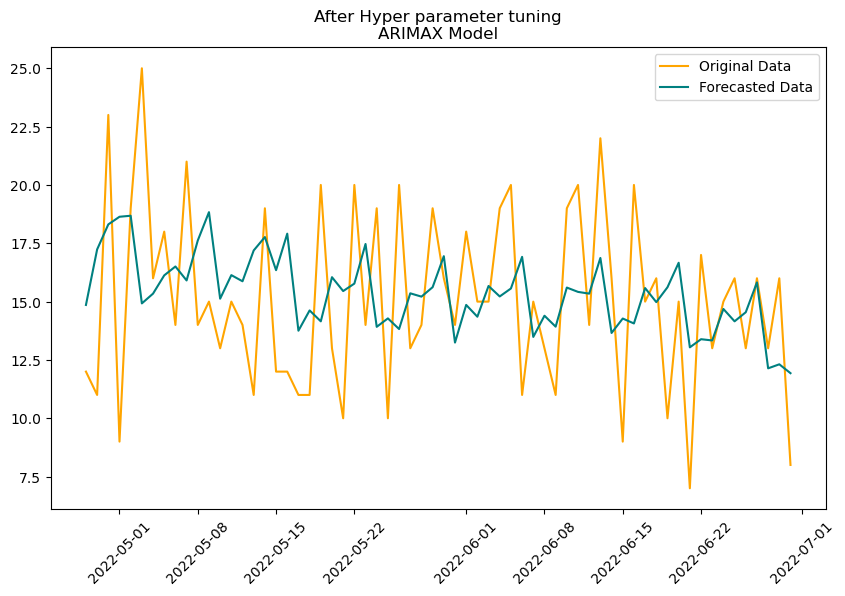

In [66]:
plot_graph("After Hyper parameter tuning\nARIMAX Model",forecast)

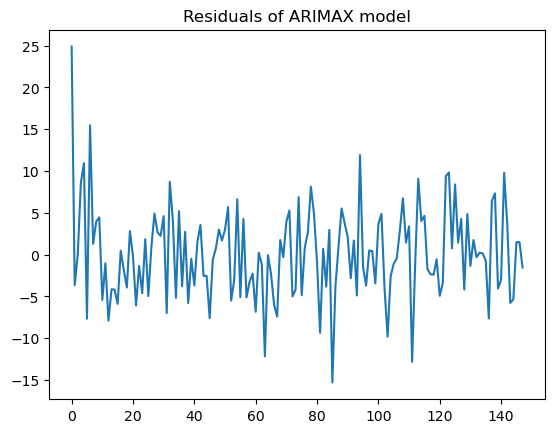

In [67]:
# Plot residuals
residuals = model_fitted.resid
plt.plot(residuals)
plt.title("Residuals of ARIMAX model")
plt.show()

In [68]:
ARIMAX = metrics("ARIMAX",forecast)

Mean Absolute Error (MAE): 3.28897083042159
Mean Squared Error (MSE): 15.614978604804143
Root Mean Squared Error (RMSE): 3.9515792545264916
Mean Absolute Percentage Error (MAPE): 24.22%


## SARIMAX Model

In [69]:
model = SARIMAX(y_train, exog=X_train, order=(1,0,3),seasonal_order=(1,1,1,12))
model_fitted = model.fit()

forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)
# print(model_fitted.summary())
print(forecast)

C:\Users\BHAVAJNA\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


148    10.753850
149    16.816431
150    17.603334
151    18.456125
152    17.606740
         ...    
207    12.303787
208    11.631258
209    15.183231
210    14.795550
211     9.640049
Name: predicted_mean, Length: 64, dtype: float64


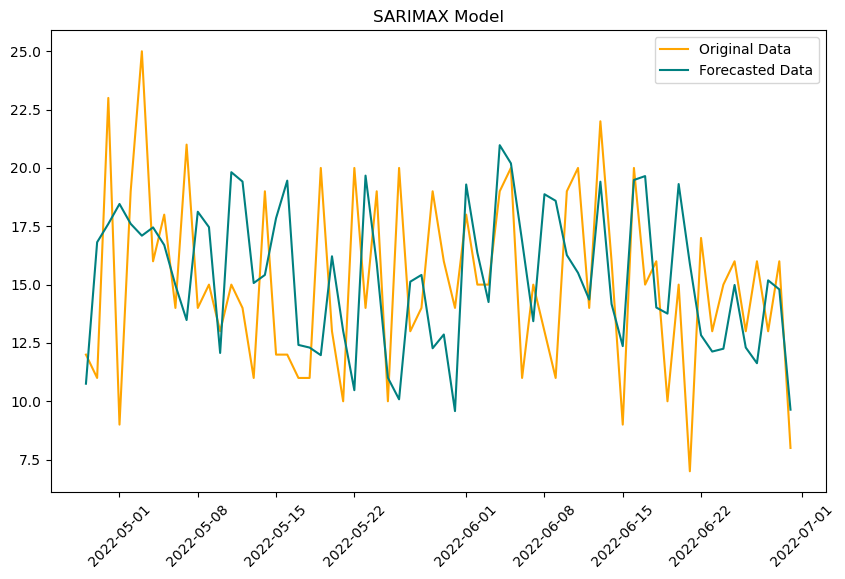

In [70]:
plot_graph("SARIMAX Model",forecast)

In [71]:
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed")
p, d, q = range(1,2), range(1), range(1,4)
P, D, Q, s = range(2), range(2), range(2), 12
best_order, best_seasonal, best_mse, best_forecast = None, None, float("inf"), None

for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
                        try:
                            model = SARIMAX(y_train, exog=X_train, order=(i, j, k), seasonal_order=(I, J, K, s)).fit(disp=False)
                            forecast = model.forecast(steps=len(y_test), exog=X_test)
                            mse = mean_squared_error(y_test, forecast)
                            if mse < best_mse:
                                best_mse, best_order, best_seasonal, best_forecast = mse, (i, j, k), (I, J, K, s), forecast
                        except:
                            continue

print(f"Best Order: {best_order}, Seasonal: {best_seasonal}, MSE: {best_mse}")

Best Order: (1, 0, 3), Seasonal: (0, 1, 1, 12), MSE: 17.77371331392884


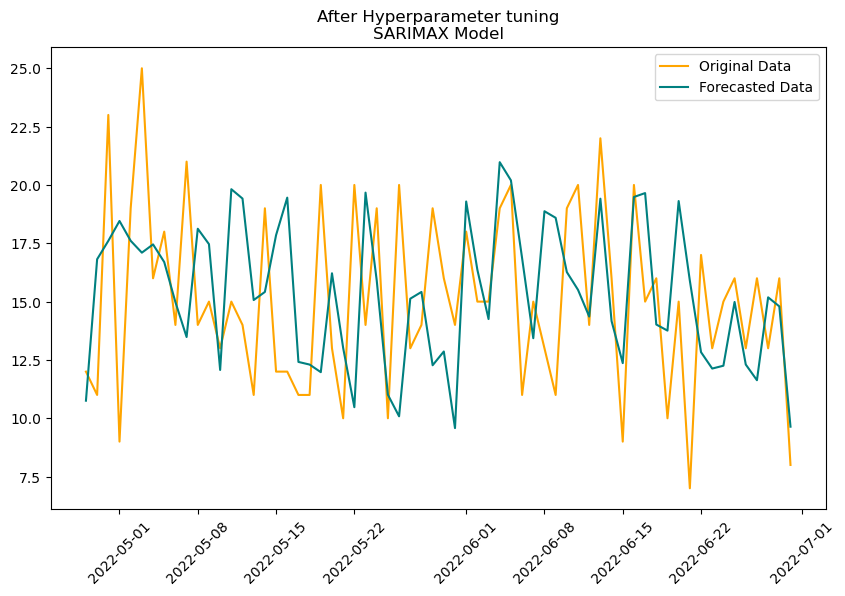

In [72]:
plot_graph("After Hyperparameter tuning\nSARIMAX Model",forecast)

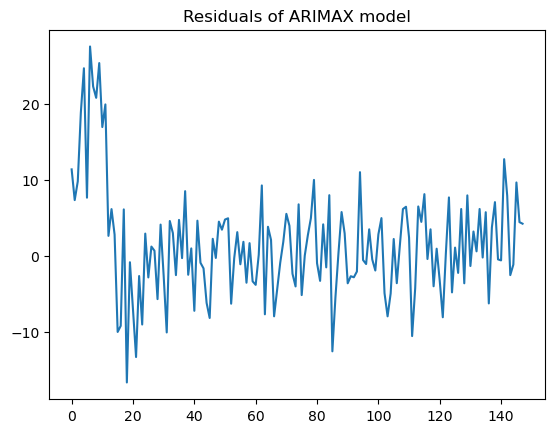

In [73]:
# Plot residuals
residuals = model_fitted.resid
plt.plot(residuals)
plt.title("Residuals of ARIMAX model")
plt.show()

In [74]:
SARIMAX = metrics("SARIMAX",forecast)

Mean Absolute Error (MAE): 3.5940935430902705
Mean Squared Error (MSE): 19.605083404307972
Root Mean Squared Error (RMSE): 4.427762799011254
Mean Absolute Percentage Error (MAPE): 25.95%


In [75]:
comparision = pd.DataFrame({
    "Model": [AR[0], MA[0], ARIMA[0], SARIMA[0], ARIMAX[0], SARIMAX[0]],
    "MAE": [AR[1], MA[1], ARIMA[1], SARIMA[1], ARIMAX[1], SARIMAX[1]],
    "MSE": [AR[2], MA[2], ARIMA[2], SARIMA[2], ARIMAX[2], SARIMAX[2]],
    "RMSE": [AR[3], MA[3], ARIMA[3], SARIMA[3], ARIMAX[3], SARIMAX[3]],
    "MAPE": [AR[4], MA[4], ARIMA[4], SARIMA[4], ARIMAX[4], SARIMAX[4]],
})

print("Evaluation Metrics: \n")
print(comparision)

Evaluation Metrics: 

     Model       MAE        MSE      RMSE       MAPE
0       AR  4.170281  25.306673  5.030574  34.583823
1       MA  4.245102  25.235820  5.023527  35.020535
2    ARIMA  4.897090  33.748165  5.809317  40.635868
3   SARIMA  5.239136  38.366776  6.194092  43.477305
4   ARIMAX  3.288971  15.614979  3.951579  24.222745
5  SARIMAX  3.594094  19.605083  4.427763  25.945179


    => SARIMAX is the better Model considering RMSE & MSE metrics

## Future Forecasting

In [76]:
test_forecast = model_fitted.forecast(steps=len(y_test), exog=X_test)

# Step 2: Create dummy exogenous variables for the next 60 points
future_X = pd.DataFrame(
    np.zeros((60, X_test.shape[1])),  # Replace with appropriate placeholders if needed
    columns=X_test.columns
)

# Step 3: Forecast for the next 60 points
future_forecast = model_fitted.forecast(steps=60, exog=future_X)

# Combine forecasts
combined_forecast = test_forecast.append(future_forecast)

C:\Users\BHAVAJNA\AppData\Local\Temp\ipykernel_2628\669801001.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_forecast = test_forecast.append(future_forecast)


In [77]:
last_test_date = pd.to_datetime(y_dates.iloc[-1]) if isinstance(y_dates, pd.Series) else pd.to_datetime(y_dates[-1])
future_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=60, freq='D')

# Append future dates to test dates
extended_dates = pd.concat([df['Day Index'], pd.Series(future_dates)], ignore_index=True)

print(extended_dates)

0     2021-12-01
1     2021-12-02
2     2021-12-03
3     2021-12-04
4     2021-12-05
         ...    
267   2022-08-25
268   2022-08-26
269   2022-08-27
270   2022-08-28
271   2022-08-29
Length: 272, dtype: datetime64[ns]


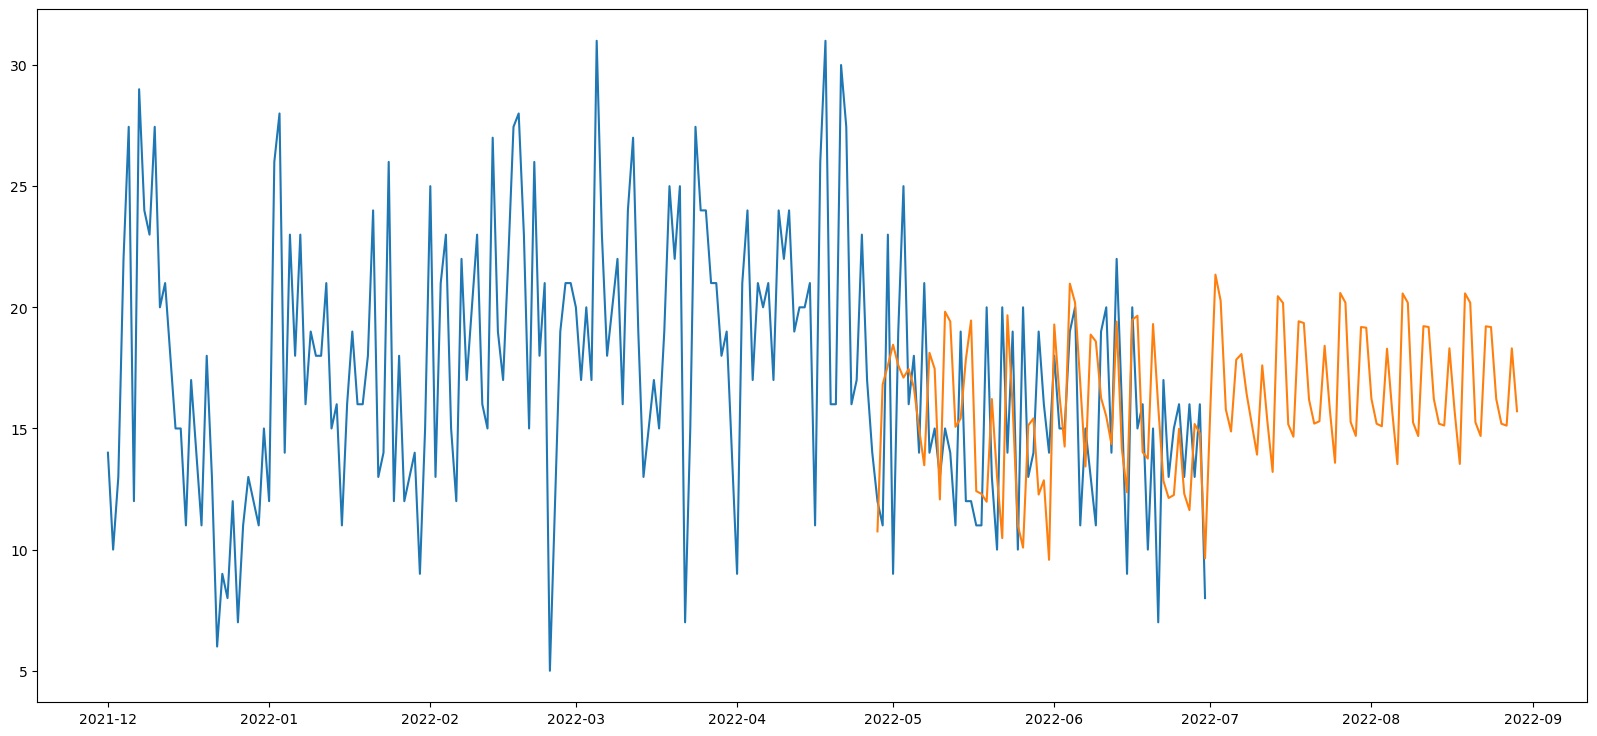

In [78]:
plt.figure(figsize=(20,9))
plt.plot(df['Day Index'],df["Quantity"])
plt.plot(extended_dates[148:],combined_forecast)